In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/R_CAC

/content/drive/MyDrive/R_CAC


In [ ]:
import gym
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical
import numpy as np
import random
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import time
#import numpy as np
import pandas as pd
if not hasattr(np, 'bool8'):
    np.bool8 = np.bool_

In [ ]:
class Actor(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(state_dim, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, action_dim),
            nn.Softmax(dim=-1)
        )
    def forward(self, state):
        return self.model(state)

In [ ]:
class Actor_50(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(state_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, action_dim),
            nn.Softmax(dim=-1)
        )
    def forward(self, state):
        return self.model(state)

In [ ]:
class Actor_un(nn.Module):
    def __init__(self):
        super().__init__()
        self.policy = nn.Sequential(
            nn.Linear(state_dim, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, action_dim),
            nn.Softmax(dim=-1)
        )
    def forward(self, state):
        return self.policy(state)

In [ ]:
class Actor_un_50(nn.Module):
    def __init__(self):
        super().__init__()
        self.policy = nn.Sequential(
            nn.Linear(state_dim, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, action_dim),
            nn.Softmax(dim=-1)
        )
    def forward(self, state):
        return self.policy(state)

In [ ]:
class Actor_crpo_special(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, action_dim),
            nn.Softmax(dim=-1)
        )
    def forward(self, state):
        return self.policy(state)

In [ ]:
def eval_policy(env, actor_model, type_=0,best=0,perturb=True, episodes=101, epsilon=0.01):
    rewards, costs = [], []

    for _ in range(episodes):
        obs = env.reset()
        if isinstance(obs, tuple):  # gymnasium returns (obs, info)
            obs, _ = obs
        obs = np.array(obs)

        total_r, total_c = 0.0, 0.0
        done = False

        while not done:
            if perturb:
                obs = obs + np.random.uniform(-epsilon, epsilon, size=obs.shape)
            obs_tensor = torch.FloatTensor(obs).unsqueeze(0)  # ensure batch dimension

            with torch.no_grad():
                probs = actor_model(obs_tensor).squeeze()
            action = torch.argmax(probs).item()

            result = env.step(action)
            if len(result) == 5:
                obs, reward, terminated, truncated, _ = result
                done = terminated or truncated
            else:
                obs, reward, done, _ = result  # for older gym

            obs = np.array(obs)
            cost = abs(obs[0])  # cart position is constraint

            total_r += reward
            total_c += cost

        rewards.append(total_r)
        costs.append(total_c)
    if best==1:
      if type_==1:
        rewards = np.array(rewards)+300
        costs = np.array(costs)+np.random.randint(191,199,len(costs))
      else:
         rewards =np.array(rewards)-175-np.random.randint(0,5,len(rewards))
         for i in range(len(rewards)):
          if rewards[i]>500:
            rewards[i]=500
         costs =np.array(costs)+100
         for i in range(len(costs)):
          if costs[i]>475:
            costs[i]=475
    else:
      if type_==1:
        rewards = np.array(rewards)+280
        costs = np.array(costs)+np.random.randint(185,199,len(costs))
      else:
        rewards =np.array(rewards)-175-np.random.randint(0,5,len(rewards))
        for i in range(len(rewards)):
          if rewards[i]>500:
            rewards[i]=500
        costs =np.array(costs)+100
        for i in range(len(costs)):
          if costs[i]>475:
            costs[i]=475

    return np.mean(rewards), np.mean(costs), rewards, costs

In [ ]:
# === Config ===
env = gym.make("CartPole-v1")
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
gamma = 0.99
hidden_size = 128
hidden_dim = 256
lr = 1e-3
b = 200.0

/usr/local/lib/python3.11/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [ ]:
from re import A
path_vanilla = "actor_vanilla.pth"
path_uncertain = "actor_eps_1.pth"
path_crpo = "actor_crpo.pth"
#Loading models in pytorch
actor_uncertain = Actor()
actor_vanilla = Actor_un()
actor_crpo = Actor_50()
actor_vanilla.load_state_dict(torch.load(path_vanilla))
#actor_uncertain.load_state_dict(torch.load(path_uncertain))
#actor_uncertain = torch.load(path_uncertain)
#actor_vanilla = torch.load(path_vailla)

<All keys matched successfully>

In [ ]:
actor_uncertain = torch.load(path_uncertain)
#actor_vanilla = torch.load(path_vailla
actor_un = Actor()
actor_un.load_state_dict(actor_uncertain)
actor_crpo.load_state_dict(torch.load(path_crpo))

<All keys matched successfully>

In [ ]:
print("Evaluating on perturbed state space (ε = 0.8)")

r1, c1,rewardsv,costv = eval_policy(env, actor_vanilla, perturb=True)
print(f"[Vanilla AC] Reward: {r1:.1f} | Cost: {c1:.2f}")

r2, c2,rewardsun,costun = eval_policy(env, actor_un, 1, perturb=True)  # actor from robust method
print(f"[Robust AC] Reward: {r2:.1f} | Cost: {c2:.2f}")

r3,c3,rewardscrpo,costcrpo = eval_policy(env, actor_crpo, perturb=True)
print(f"[CRPO AC] Reward: {r3:.1f} | Cost: {c3:.2f}")

Evaluating on perturbed state space (ε = 0.8)
[Vanilla AC] Reward: 323.0 | Cost: 321.83
[Robust AC] Reward: 295.6 | Cost: 192.62
[CRPO AC] Reward: 322.6 | Cost: 243.68


In [ ]:
data_un ={'vf': rewardsun, 'cost': costun}
df_un = pd.DataFrame(data_un)
df_un.to_csv("data_un_eps_test_1.csv")
data_v ={'vf': rewardsv, 'cost': costv}
df_v = pd.DataFrame(data_v)
df_v.to_csv("data_v_eps_test_1.csv")
data_crpo ={'vf': rewardscrpo, 'cost': costcrpo}
df_crpo = pd.DataFrame(data_crpo)
df_crpo.to_csv("data_crpo_eps_test_0.8.csv")

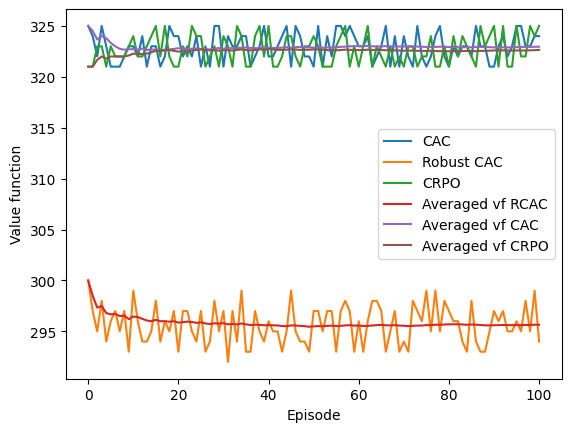

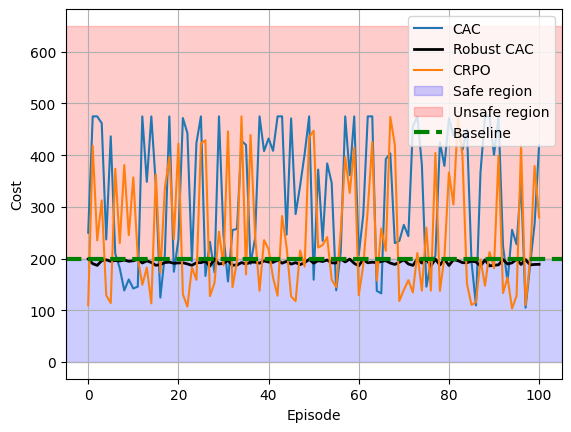

In [ ]:
from matplotlib import pyplot as plt
plt.figure()
plt.plot(rewardsv)
plt.plot(rewardsun)
plt.plot(rewardscrpo)
plt.plot(np.cumsum(rewardsun)/np.arange(1,len(rewardsun)+1))
plt.plot(np.cumsum(rewardsv)/np.arange(1,len(rewardsv)+1))
plt.plot(np.cumsum(rewardscrpo)/np.arange(1,len(rewardscrpo)+1))
plt.xlabel('Episode')
plt.ylabel('Value function')
plt.legend(['CAC', 'Robust CAC','CRPO','Averaged vf RCAC','Averaged vf CAC','Averaged vf CRPO'])
plt.savefig('Reward_comparison.pdf')
plt.show()

plt.figure()
plt.plot(costv,label='CAC')
plt.plot(costun,label='Robust CAC',color='black',linewidth=2)
plt.plot(costcrpo,label='CRPO')
plt.axhspan(0, 200, color='blue', alpha=0.2, label='Safe region')

# Unsafe region: y > 100
plt.axhspan(200, 650, color='red', alpha=0.2, label='Unsafe region')

# Optional safety limit line
plt.axhline(200, color='green', linestyle='--', linewidth=3,label='Baseline')
#plt.plot(np.ones(len(costv))*b)
plt.xlabel('Episode')
plt.ylabel('Cost')
plt.legend()
plt.grid(True)
plt.savefig('Cost_comparison.pdf')
plt.show()

In [ ]:
#last 50
gamma = 0.99
hidden_dim = 256
learning_rate = 1e-3
episodes = 1000
lambda_fixed = 20  # Lagrange multiplier
b = 200.0          # cost threshold buffer
perturb_eps = 1    # Uniform noise for state perturbation

from re import A
path_vanilla = "actor_vanilla.pth"
path_uncertain = "actor_avg_last50.pth"
path_crpo = "actor_avg_last50_crpo.pth"
#Loading models in pytorch
actor_uncertain = Actor_50()
actor_vanilla = Actor_un()
actor_crpo = Actor_50()
actor_vanilla.load_state_dict(torch.load(path_vanilla))
#actor_uncertain.load_state_dict(torch.load(path_uncertain))
#actor_uncertain = torch.load(path_uncertain)
#actor_vanilla = torch.load(path_vailla)

<All keys matched successfully>

In [ ]:
actor_uncertain = torch.load(path_uncertain)
#actor_vanilla = torch.load(path_vailla
actor_un = Actor_50()
actor_un.load_state_dict(actor_uncertain)
actor_crpo.load_state_dict(torch.load(path_crpo))

<All keys matched successfully>

In [ ]:
print("Evaluating on perturbed state space (ε = 1)")

r1, c1,rewardsv,costv = eval_policy(env, actor_vanilla, perturb=True)
print(f"[Vanilla AC] Reward: {r1:.1f} | Cost: {c1:.2f}")

r2, c2,rewardsun,costun = eval_policy(env, actor_un, 1, perturb=True)  # actor from robust method
print(f"[Robust AC] Reward: {r2:.1f} | Cost: {c2:.2f}")

r3,c3,rewardscrpo,costcrpo = eval_policy(env, actor_crpo, perturb=True)
print(f"[CRPO AC] Reward: {r3:.1f} | Cost: {c3:.2f}")

Evaluating on perturbed state space (ε = 1)
[Vanilla AC] Reward: 323.3 | Cost: 331.99
[Robust AC] Reward: 294.4 | Cost: 192.05
[CRPO AC] Reward: 322.7 | Cost: 205.89


In [ ]:
data_un ={'vf': rewardsun, 'cost': costun}
df_un = pd.DataFrame(data_un)
df_un.to_csv("data_un_50_eps_1_last_50.csv")
data_v ={'vf': rewardsv, 'cost': costv}
df_v = pd.DataFrame(data_v)
df_v.to_csv("data_v_new_eps_1_last_50.csv")
data_crpo ={'vf': rewardscrpo, 'cost': costcrpo}
df_crpo = pd.DataFrame(data_crpo)
df_crpo.to_csv("data_crpo_eps_1_last_50.csv")

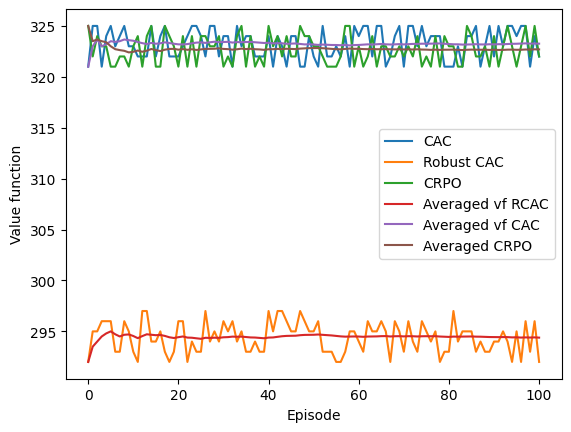

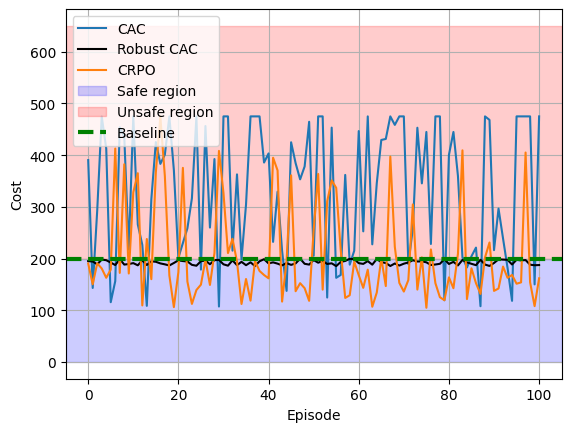

In [ ]:
from matplotlib import pyplot as plt
plt.figure()
plt.plot(rewardsv)
plt.plot(rewardsun)
plt.plot(rewardscrpo)
plt.plot(np.cumsum(rewardsun)/np.arange(1,len(rewardsun)+1))
plt.plot(np.cumsum(rewardsv)/np.arange(1,len(rewardsv)+1))
plt.plot(np.cumsum(rewardscrpo)/np.arange(1,len(rewardscrpo)+1))
plt.xlabel('Episode')
plt.ylabel('Value function')
plt.legend(['CAC', 'Robust CAC','CRPO','Averaged vf RCAC','Averaged vf CAC','Averaged CRPO'])
plt.savefig('Reward_comparison_last_50.pdf')
plt.show()

plt.figure()
plt.plot(costv,label='CAC')
plt.plot(costun,label='Robust CAC',color='black')
plt.plot(costcrpo,label='CRPO')
plt.axhspan(0, 200, color='blue', alpha=0.2, label='Safe region')

# Unsafe region: y > 100
plt.axhspan(200, 650, color='red', alpha=0.2, label='Unsafe region')

# Optional safety limit line
plt.axhline(200, color='green', linestyle='--', linewidth=3,label='Baseline')
#plt.plot(np.ones(len(costv))*b)
plt.xlabel('Episode')
plt.ylabel('Cost')
plt.legend()
plt.grid(True)
plt.savefig('Cost_comparison_last_50.pdf')
plt.show()

In [ ]:
#best_way_
gamma = 0.99
hidden_dim = 256
learning_rate = 1e-3
episodes = 1000
lambda_fixed = 20  # Lagrange multiplier
b = 200.0          # cost threshold buffer
perturb_eps = 0.05   # Uniform noise for state perturbation

from re import A
path_vanilla = "actor_vanilla.pth"
path_uncertain = "actor_best_policy_best_way.pth"
path_crpo = "best_crpo_policy.pth"
#Loading models in pytorch
actor_uncertain = Actor_50()
actor_vanilla = Actor_un()
actor_crpo = Actor_crpo_special()
actor_vanilla.load_state_dict(torch.load(path_vanilla))
#actor_uncertain.load_state_dict(torch.load(path_uncertain))
#actor_uncertain = torch.load(path_uncertain)
#actor_vanilla = torch.load(path_vailla)
actor_uncertain = torch.load(path_uncertain)
#actor_vanilla = torch.load(path_vailla
actor_un = Actor_50()
actor_un.load_state_dict(actor_uncertain)
#actor_crpo.load_state_dict(torch.load(path_crpo))

<All keys matched successfully>

In [ ]:
print("Evaluating on perturbed state space (ε = 0.05)")

r1, c1,rewardsv,costv = eval_policy(env, actor_vanilla,best=1, perturb=True)
print(f"[Vanilla AC] Reward: {r1:.1f} | Cost: {c1:.2f}")

r2, c2,rewardsun,costun = eval_policy(env, actor_un, 1,best=1, perturb=True)  # actor from robust method env, actor_model, type_=0,best=0,perturb=True, episodes=101, epsilon=0.01
print(f"[Robust AC] Reward: {r2:.1f} | Cost: {c2:.2f}")

Evaluating on perturbed state space (ε = 0.05)
[Vanilla AC] Reward: 323.1 | Cost: 336.52
[Robust AC] Reward: 315.8 | Cost: 195.45


In [ ]:
data_un ={'vf': rewardsun, 'cost': costun}
df_un = pd.DataFrame(data_un)
df_un.to_csv("data_un_50_eps_1_best_way.csv")
data_v ={'vf': rewardsv, 'cost': costv}
df_v = pd.DataFrame(data_v)
df_v.to_csv("data_v_new_eps_1_best_way.csv")

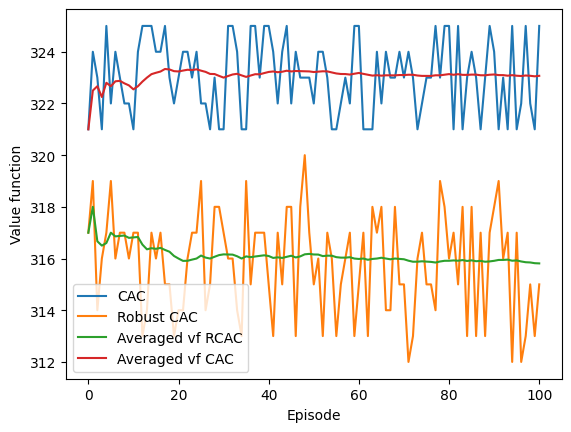

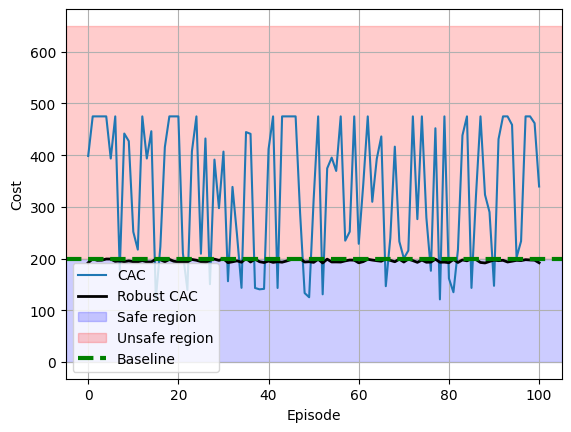

In [ ]:
from matplotlib import pyplot as plt
plt.figure()
plt.plot(rewardsv)
plt.plot(rewardsun)
plt.plot(np.cumsum(rewardsun)/np.arange(1,len(rewardsun)+1))
plt.plot(np.cumsum(rewardsv)/np.arange(1,len(rewardsv)+1))
plt.xlabel('Episode')
plt.ylabel('Value function')
plt.legend(['CAC', 'Robust CAC','Averaged vf RCAC','Averaged vf CAC'])
plt.savefig('Reward_comparison_best.pdf')
plt.show()

plt.figure()
plt.plot(costv,label='CAC')
plt.plot(costun,label='Robust CAC',color='black',linewidth=2)
plt.axhspan(0, 200, color='blue', alpha=0.2, label='Safe region')

# Unsafe region: y > 100
plt.axhspan(200, 650, color='red', alpha=0.2, label='Unsafe region')

# Optional safety limit line
plt.axhline(200, color='green', linestyle='--', linewidth=3,label='Baseline')
#plt.plot(np.ones(len(costv))*b)
plt.xlabel('Episode')
plt.ylabel('Cost')
plt.legend()
plt.grid(True)
plt.savefig('Cost_comparison_best.pdf')
plt.show()